In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot
import tensorflow as tf
import pickle
import os

In [2]:
import dataset_utils
from glob import glob

In [22]:
def parse_dataset(num_points, DATA_DIR):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob(os.path.join(folder, "train/*"))
        test_files = glob(os.path.join(folder, "test/*"))

        all_train_points=[]
        for f in train_files:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                all_train_points.append(data)
                
                concatenated_train_points = np.concatenate(all_train_points, axis=0)
                sampled_indices = np.random.choice(concatenated_train_points.shape[0], size=num_points, replace=True)
                sampled_data = concatenated_train_points[sampled_indices].astype(np.float16)
                train_points.append(sampled_data)
                train_labels.append(i)
               
        all_test_points = []
        for f in test_files:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                all_test_points.append(data)
                
                concatenated_test_points = np.concatenate(all_test_points, axis=0)
                sampled_indices = np.random.choice(concatenated_test_points.shape[0], size=num_points, replace=True)
                sampled_data = concatenated_test_points[sampled_indices].astype(np.float16)
                test_points.append(sampled_data)
                test_labels.append(i)
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [23]:
DATA_DIR = "data/bg_rm_entire_field_raw_3_class"
NUM_POINTS = 100
NUM_FRAMES = 3
NUM_CLASSES = 3
BATCH_SIZE = 32
train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS, DATA_DIR)

# Verify the shapes
print(f"train_points shape: {train_points.shape}")
print(f"test_points shape: {test_points.shape}")
print(f"train_labels shape: {np.array(train_labels).shape}")
print(f"test_labels shape: {np.array(test_labels).shape}")

processing class: walking
processing class: jumping
train_points shape: (152, 100, 5)
test_points shape: (38, 100, 5)
train_labels shape: (152,)
test_labels shape: (38,)


In [24]:
from tensorflow import data as tf_data
import keras
import PointNET

keras.utils.set_random_seed(seed=42)

In [25]:
train_size = 0.8
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
train_dataset_size = int(len(dataset) * train_size)

dataset = dataset.shuffle(len(train_points)).map(PointNET.augment)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

In [26]:
import keras
import tensorflow as tf
from keras import ops
from keras import layers
from PointNET import tnet, conv_bn, dense_bn
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer

In [27]:
import tensorflow as tf
from tensorflow import data as tf_data
import keras
from keras import layers
import numpy as np

keras.utils.set_random_seed(seed=42)

def create_pointnet_model(input_shape, num_points, num_features):
    inputs = keras.Input(shape=input_shape)

    # PointNet feature extraction
    x = tnet(inputs, num_features)
    
    # Convolutional layers
    x = conv_bn(x, 64)
    x = conv_bn(x, 64)
    x = conv_bn(x, 128)
    x = conv_bn(x, 1024)
    
    # GlobalMaxPooling1D
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Reshape((-1, 1024))(x)
    
    # Bidirectional LSTM layers
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Flatten()(x)
    # Fully connected layer
    x = layers.Dense(256, activation='relu')(x)
    
    # Final dense layer
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet_lstm")
    return model

# Usage
input_shape = (NUM_POINTS, 5)  # Adjust this based on your input data
num_points = 20  # Number of points sampled per node and frame
num_features = 5  # Features per point (R, v, x, y, SNR, in, if)

model = create_pointnet_model(input_shape, num_points, num_features)
model.summary()


Model: "pointnet_lstm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 100, 32)   │        192 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 32)   │        128 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 100, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 100, 64)   │      2,112 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 100, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 100, 512)  │     33,280 │ activation_19[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 512)  │      2,048 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 100, 512)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ activation_20[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │    131,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │     32,896 │ activation_21[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_11[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 25)        │      3,225 │ activation_22[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 5, 5)      │          0 │ dense_12[0][0]  

 Total params: 3,112,668 (11.87 MB)

 Trainable params: 3,108,124 (11.86 MB)

 Non-trainable params: 4,544 (17.75 KB)

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os


In [29]:
INIT_TIMESTAMP = "5_09_2024_pointlstm_bg_rm"
checkpoint_dir = os.path.join('model/checkpoints/', INIT_TIMESTAMP)
os.makedirs(checkpoint_dir, exist_ok=True)

In [30]:
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'iter-{epoch:02d}.weights.h5'),  # Save weights after each epoch
    save_weights_only=True,  # Save only weights, not the entire model
    verbose=1  # Print a message when saving
)

In [31]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=[checkpoint_callback]  # Add the checkpoint callback here
)

Epoch 1/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 8.7197 - sparse_categorical_accuracy: 0.3802
Epoch 1: saving model to model/checkpoints/5_09_2024_pointlstm_bg_rm/iter-01.weights.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - loss: 8.2551 - sparse_categorical_accuracy: 0.3868 - val_loss: 5.5344 - val_sparse_categorical_accuracy: 0.5806
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 5.7416 - sparse_categorical_accuracy: 0.5837
Epoch 2: saving model to model/checkpoints/5_09_2024_pointlstm_bg_rm/iter-02.weights.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 5.6444 - sparse_categorical_accuracy: 0.5777 - val_loss: 4.3030 - val_sparse_categorical_accuracy: 0.8710
Epoch 3/30
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 4.7204 - sparse_categorical_accuracy: 0.9757
Epoch 3: saving model to model/checkpoints/5_09_2024_pointlstm_bg_rm/iter-03.weights.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.5564 - sparse_categorical_accuracy: 0.9623 - val_loss: 4.2305 - val_sparse_ca

In [32]:
from matplotlib import pyplot as plt

2024-09-06 01:03:51.185053: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
[[[ 3.4985e-01  2.2305e+00  1.0215e+00  2.5049e-01  1.4400e+02]
  [-1.3955e+00  5.9766e-01  5.9863e-01  0.0000e+00  1.2300e+02]
  [ 3.8403e-01  2.3457e+00  1.3027e+00  3.7573e-01  2.7900e+02]
  ...
  [ 2.2598e+00  2.7754e+00  1.0859e+00  0.0000e+00  1.6000e+02]
  [ 3.4180e-01  1.2891e-01  8.8770e-01  0.0000e+00  1.3500e+02]
  [ 1.9922e+00  3.8652e+00  2.0820e+00  0.0000e+00  1.1200e+02]]

 [[ 3.6621e-02  1.8789e+00  4.8340e-01 -2.5049e-01  1.6100e+02]
  [ 3.8574e-01  1.5420e+00  6.0156e-01  6.2598e-01  2.9600e+02]
  [-4.9805e-01  2.5391e+00  8.1836e-01 -1.0020e+00  1.9700e+02]
  ...
  [ 1.5840e+00 -1.2891e-01  1.8027e+00  0.0000e+00  1.2800e+02]
  [ 4.0723e-01  2.3008e+00  3.7109e-01  3.7573e-01  1.2100e+02]
  [ 3.4180e-01  1.1719e-01  9.2773e-01  0.0000e+00  1.3800e+02]]

 [[ 4.9438e-01  1.0938e-01  9.1992e-01  0.0000e+00  1.3800e+02]
  [-4.0625e-01  2.7227e+00  1.3125e+00 -1.0020e+00  2.2200e+02]
  [-1.6797e-01  2.2910e+00  6.9629e-01  2.5049e-0

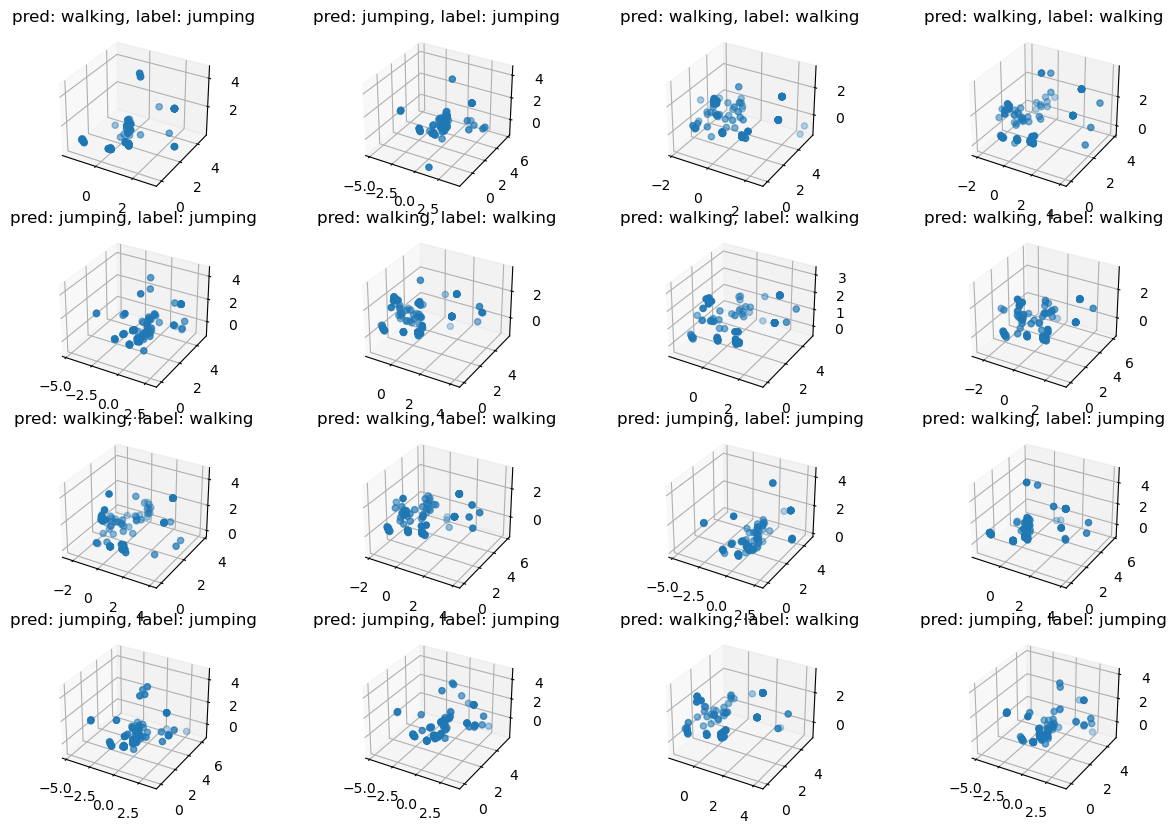

In [33]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:20, ...]
labels = labels[:20, ...]

# run test data through model
preds = model.predict(points)
preds = ops.argmax(preds, -1)

points = points.numpy()
print(points)

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_on()
plt.show()

In [34]:
predictions = []

# Calculate the number of sections, ensure it's at least 1
num_sections = max(1, len(test_points) // NUM_POINTS)

for batch in np.array_split(test_points, num_sections): 
    preds = model.predict(batch)
    preds = np.argmax(preds, axis=-1)
    predictions.extend(preds)

predictions = np.array(predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


In [35]:
accuracy = np.sum(predictions == test_labels) / len(test_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 94.74%


In [36]:
print(test_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1]


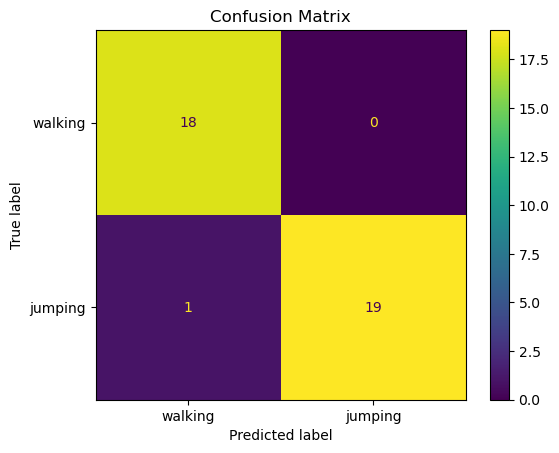

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plotting the confusion matrix
# Compute the confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plotting the confusion matrix
class_names = ['walking', 'jumping']  # Based on your CLASS_MAP
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

# Display the plot
disp.plot()
plt.title("Confusion Matrix")
plt.show()


In [37]:
#reload model
reload_model = create_pointnet_model(input_shape, num_points, num_features)
reload_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

In [50]:
reload_model.load_weights('model/checkpoints/5_09_2024_pointnet_lstm/iter-20.weights.h5')

/Users/katiezhou/mambaforge/envs/py38/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 98 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
